In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/BSNIP'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['Age_cal'].keys()))
print(len(subs))

1244


In [92]:
import numpy as np

task = 'unk'
x = []
y = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
    y.append(demo['DXGROUP_1'][sub] == 'SZP')
#     y.append(int(demo['Age_cal'][sub]))
#     y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(199, 34716)
(199,)
[1 1 1 1 1]


In [262]:
from sklearn.model_selection import train_test_split

import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class Basis(nn.Module):
    def __init__(self, dims, rank, nsubs):
        super(Basis, self).__init__()
        self.c = nn.Parameter(0.01*torch.randn(dims[0],264,rank).float().cuda())
        self.g1 = nn.Parameter(0.01*torch.randn(dims[1],264,rank).float().cuda())
        self.g2 = nn.Parameter(0.01*torch.randn(dims[2],264,rank).float().cuda())
        self.wc = nn.Parameter(torch.randn(nsubs, dims[0]).float().cuda())
        self.wg1 = nn.Parameter(torch.randn(nsubs, dims[1]).float().cuda())
        self.wg2 = nn.Parameter(torch.randn(nsubs, dims[2]).float().cuda())
        self.mask = nn.Parameter(0*torch.randn(nsubs).float().cuda())
        self.s = nn.Sigmoid()
        
    def get_mask_loss(self):
        m = self.s(self.mask)
        loss = -torch.mean(m*torch.log(m)+(1-m)*torch.log(1-m))
        return loss
    
    def get_occupancy_loss(self):
        m = self.s(self.mask)
        return torch.abs(torch.mean(m-0.5))
        
    def compute(self, group, dim):
        if group == 0:
            A = self.c[dim]
        elif group == 1:
            A = self.g1[dim]
        else:
            A = self.g2[dim]
        A = A@A.T
        A = A/torch.linalg.norm(A)
        a,b = torch.triu_indices(264,264,offset=1)
        return A[a,b]
    
    def recon(self, apply_mask):
        m = self.s(self.mask)
        xc, xg1, xg2 = [], [], []
        for c in range(self.c.shape[0]):
            A = self.compute(0, c)
            A = A.unsqueeze(0)*self.wc[:,c:c+1]
            xc.append(A)
        for g in range(self.g1.shape[0]):
            A = self.compute(1, g)
            A = A.unsqueeze(0)*self.wg1[:,g:g+1]
            if apply_mask:
                A = A*m.unsqueeze(1)
            xg1.append(A)
        for g in range(self.g2.shape[0]):
            A = self.compute(2, g)
            A = A.unsqueeze(0)*self.wg2[:,g:g+1]
            if apply_mask:
                A = A*(1-m).unsqueeze(1)
            xg2.append(A)
        xc = sum(xc)
        xg1 = sum(xg1)
        xg2 = sum(xg2)
        x = sum([xc, xg1, xg2])
        return x
    
#     def to_img(self, dim=0):
#         A = self.A[dim]
#         A = A@A.T
#         A = A/torch.linalg.norm(A)
#         return A.detach().cpu().numpy()
    
#     def scramble(self, dim):
#         with torch.no_grad():
#             self.A[dim] *= 0
#             self.A[dim] += torch.randn(264,5).float().cuda()
    
# xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.8)

# xtr = x[np.where(y == 1)[0]]
# print(xtr.shape)

res = []

for _ in range(20):
    xtr = x

    xtr = torch.from_numpy(xtr).float().cuda()
    # xt = torch.from_numpy(xt).float().cuda()
    # ytr = torch.from_numpy(ytr).float().cuda()
    # yt = torch.from_numpy(yt).float().cuda()

    # mu = torch.mean(ytr)
    # ytr = ytr-mu
    # yt = yt-mu

    basis = Basis([0,1,1],2,xtr.shape[0])
    optim = torch.optim.Adam(basis.parameters(), lr=1e-1, weight_decay=0)

    nepochs = 1000
    pperiod = 100

    def rmse(a,b):
        return torch.mean((a-b)**2)**0.5

    for epoch in range(nepochs):
        optim.zero_grad()
        apply_mask = True #epoch > 0
        xhat = basis.recon(apply_mask)
        rloss = rmse(xtr, xhat)
        mloss = basis.get_mask_loss() if apply_mask else 0
        oloss = basis.get_occupancy_loss() if apply_mask else 0
        (mloss+rloss+oloss).backward()
        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs:
            print(f'{epoch} {float(rloss)} {float(mloss)} {float(oloss)}')

    print('Complete')

    res.append(basis.s(basis.mask).detach().cpu().numpy())

0 0.30042850971221924 0.6931471228599548 0.0
100 0.27290359139442444 0.08011119812726974 0.0002890999021474272
200 0.2497960925102234 0.016611576080322266 0.0019876081496477127
300 0.23370100557804108 0.008280766196548939 0.0023176944814622402
400 0.22245673835277557 0.005132037214934826 0.002412589965388179
500 0.21477492153644562 0.0035495341289788485 0.002452363958582282
600 0.20962916314601898 0.0026249398943036795 0.0024726546835154295
700 0.20622862875461578 0.0020311884582042694 0.0024843192659318447
800 0.20400287210941315 0.0016238208627328277 0.0024916466791182756
900 0.20255643129348755 0.0013307809131219983 0.0024964988697320223
Complete
0 0.3004271686077118 0.6931471228599548 0.0
100 0.27313825488090515 0.09135270118713379 0.00013729075726587325
200 0.24989113211631775 0.01945907063782215 9.479234904574696e-06
300 0.23371393978595734 0.011440093629062176 5.01278054798604e-06
400 0.22242577373981476 0.008430356159806252 1.4658548934676219e-06
500 0.21471962332725525 0.00691

KeyboardInterrupt: 

99.975586 0.021887854
50.997776 48.999702
50.99751 48.99997
49.9993 49.998184
44.00272 55.99476
54.495373 45.502106
52.996063 47.001415
54.99778 44.999706


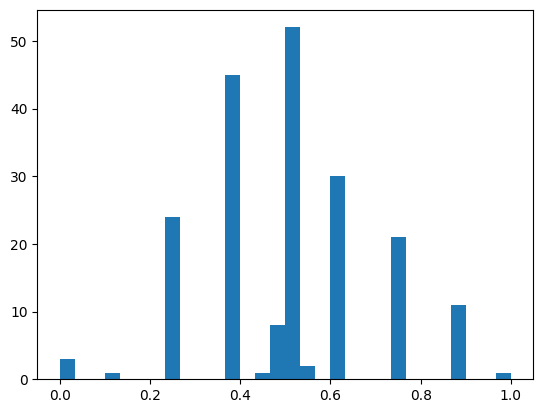

In [264]:
rr = []

for r in res:
    m1 = np.sum(res[0]*r)
    m2 = np.sum(res[0]*(1-r))
    print(m1,m2)
    if m2 > m1:
        rr.append(1-r)
    else:
        rr.append(r)

rstk = np.stack(rr)

# plt.plot(np.mean(rstk, axis=0))
plt.hist(np.mean(rstk, axis=0), bins=30)
plt.show()

In [230]:
basis.wc[:,0]

tensor([ 24.4942,  -1.2177,   1.0321,   2.0539,  21.6874,   5.6524,  16.8863,
         14.7277,  -0.2475,  18.9974,  10.8914,   6.2771,   7.7747,  -9.9848,
          5.1470,   5.6581,   9.5620,  19.6066,  16.5040,  32.2159,   5.0293,
         20.9398,   1.8255,  -1.1226,   5.8522,  -4.0098,   1.1486,  17.6140,
         -4.1787,   0.6097,  15.4720,  10.6544,   0.4683,  19.9038,  24.0508,
          3.5339,   7.5238,  -0.2476,  -3.1410,   3.7399,   5.4197,  13.3893,
         46.8780,  -1.4217, -12.5313,  11.8409,  23.4416,   4.7494,   9.0025,
         17.4318,   0.5865,   6.4123,  10.2682,  13.7334,  20.2154,   5.8791,
         14.3158,  -4.7335,   2.6664,  16.8940,   4.7565,   1.0292,  -1.7047,
          6.5351,  -2.5276,  11.8673,   6.2418,  13.5795, -10.0958,  -9.0551,
         -6.1671,  -1.6101,   4.5971,  -5.2927,   3.0026,  -8.6432, -12.3873,
         12.7223, -13.7263,  -3.1900,  13.6141,  -1.5162,  -2.5552,  -1.6897,
         -8.2202,  16.8412,  -0.0778,  -2.9743,  -0.5690,   1.06

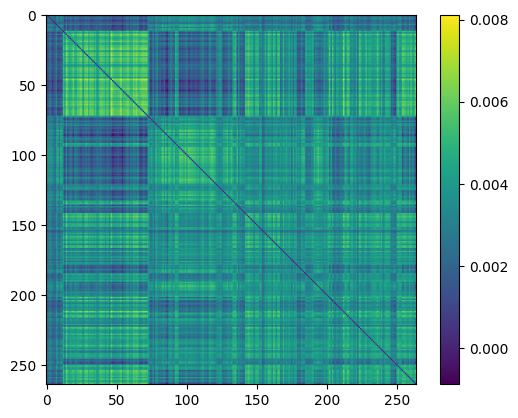

In [266]:
import matplotlib.pyplot as plt

def vec2mat(p):
    if isinstance(p, torch.Tensor):
        p = p.detach().cpu().numpy()
    m = np.zeros((264,264))
    a,b = np.triu_indices(264,1)
    m[a,b] = p
    return m+m.T

plt.imshow(vec2mat(basis.compute(2,0)))
plt.colorbar()
plt.show()

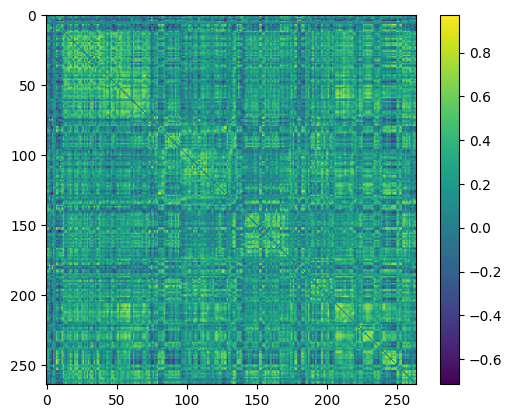

In [109]:
plt.imshow(vec2mat(xtr[0]))
plt.colorbar()
plt.show()

In [110]:
szsubs = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP']:
        continue
    szsubs.append(sub)
    
print(len(szsubs))

g1subs, g2subs = [], []

for i,sub in enumerate(szsubs):
    if basis.s(basis.mask)[i] > 0.5:
        g1subs.append(sub)
    else:
        g2subs.append(sub)
        
print(len(g1subs))
print(len(g2subs))

199
191
8


In [47]:
ncsubs = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['NC']:
        continue
    ncsubs.append(sub)
    
print(len(ncsubs))

242


In [83]:
from sklearn.linear_model import LogisticRegression
import random

accs = []

for _ in range(30):   
    random.shuffle(ncsubs)

    task = 'unk'
    x = []
    y = []

    for sub in g2subs + ncsubs[:len(g1subs)]:
        p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
        x.append(p)
        y.append(demo['DXGROUP_1'][sub] == 'SZP')

    x = np.stack(x)
    y = np.array(y).astype('int')

    # print(x.shape)
    # print(y.shape)
    # print(y[0:5])
    
    xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.8)

    clf = LogisticRegression(max_iter=1000).fit(xtr, ytr)
    yhat = clf.predict(xt)
    acc = np.mean(yhat == yt)
    accs.append(acc)
    print(acc)
    
print('---')
print(np.mean(accs))
print(np.std(accs))

0.675
0.825
0.675
0.725
0.75
0.7
0.675
0.7
0.675
0.675
0.725
0.675
0.575
0.7
0.8
0.725
0.725
0.7
0.775
0.825
0.75
0.775
0.725
0.575
0.675
0.675
0.65
0.65
0.775
0.625
---
0.7058333333333332
0.06112941645031102


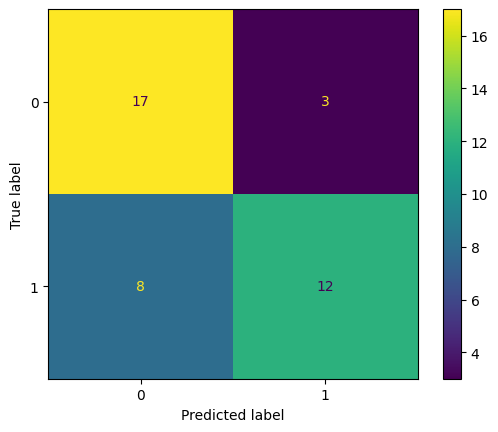

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(yt, yhat)
plt.show()